In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
import theano
import theano.tensor.signal.downsample

Using gpu device 0: GeForce GTX 780


# CIFAR10

In [3]:
# We will now build a convolutional network for the CIFAR-10 data. We will use Theano.

In [4]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = ((ScaleAndShift, [2.0 / 255.0, -1], {"which_sources" : "features"}),
                                (Cast, [np.float32], {"which_sources" : "features"}))

cifar10_train = CIFAR10(("train",), subset = slice(None, 40000))
# this stream will shuffle the CIFAR-10 set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(cifar10_train,
                                                 iteration_scheme = ShuffledScheme(cifar10_train.num_examples, 25))
                                               
cifar10_validation = CIFAR10(("train",), subset = slice(40000, None))

# We will use larger portions for testing and validation
# as these don't do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(cifar10_validation,
                                                      iteration_scheme = SequentialScheme(cifar10_validation.num_examples, 100))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(cifar10_test,
                                                iteration_scheme = SequentialScheme(cifar10_test.num_examples, 100))

In [5]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [6]:
# These are taken from https://github.com/mila-udem/blocks.

class Constant():
    '''Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    '''
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype = np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    '''Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    '''
    def __init__(self, std = 1, mean = 0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size = shape)
        return m.astype(np.float32)


class Uniform():
    '''Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width / 2, mean + width / 2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    '''
    def __init__(self, mean = 0., width = None, std = None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1 / 12 * width ^ 2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size = shape)
        return m.astype(np.float32)

In [7]:
# A theano variable is an entry to the cmputational graph
# We will need to provide its value during function call
# X is batch_size x num_channels x img_rows x img_columns
X = theano.tensor.tensor4("X")

# Y is 1D, it lists the targets for all examples
Y = theano.tensor.matrix("Y", dtype = "uint8")

# The tag values are useful during debugging the creation of Theano graphs

X_test_value, Y_test_value = next(cifar10_train_stream.get_epoch_iterator())

# Unfortunately, test tags don't work with convolutions with newest Theano :(
theano.config.compute_test_value = "off" # Enable the computation of test values


X.tag.test_value = X_test_value[: 3]
Y.tag.test_value = Y_test_value[: 3]

print "X shape: %s" % (X.tag.test_value.shape,)

# this list will hold all parameters of the network
model_parameters = []

# The first convolutional layer
# The shape is: num_out_filters x num_in_filters x filter_height x filter_width
num_filters_1 = 10 # we will apply that many convolution filters in the first layer
CW1 = theano.shared(np.zeros((num_filters_1, 3, 5, 5), dtype = "float32"),
                    name = "CW1")
# please note - this is somewhat non-standard
CW1.tag.initializer = IsotropicGaussian(0.05)

CB1 = theano.shared(np.zeros((num_filters_1,), dtype = "float32"),
                    name = "CB1")
CB1.tag.initializer = Constant(0.0)
model_parameters += [CW1, CB1]

after_C1 = theano.tensor.maximum(0.0,
                                 theano.tensor.nnet.conv2d(X, CW1) + CB1.dimshuffle("x", 0, "x", "x"))
# print "after_C1 shape: %s" % (after_C1.tag.test_value.shape,)
after_P1 = theano.tensor.signal.downsample.max_pool_2d(after_C1, (2, 2), ignore_border = True)
# print "after_P1 shape: %s" % (after_P1.tag.test_value.shape,)


num_filters_2 = 25 # we will compute ten convolution filters in the first layer
CW2 = theano.shared(np.zeros((num_filters_2, num_filters_1, 5, 5), dtype = "float32"),
                   name = "CW2")
CW2.tag.initializer = IsotropicGaussian(0.05)

CB2 = theano.shared(np.zeros((num_filters_2,), dtype = "float32"),
                    name = "CB2")
CB2.tag.initializer = Constant(0.0)
model_parameters += [CW2, CB2]

after_C2 = theano.tensor.maximum(0.0,
                                 theano.tensor.nnet.conv2d(after_P1, CW2) + CB2.dimshuffle("x", 0, "x", "x"))
# print "after_C2 shape: %s" % (after_C2.tag.test_value.shape,)
after_P2 = theano.tensor.signal.downsample.max_pool_2d(after_C2, (2, 2), ignore_border = True)
# print "after_P2 shape: %s" % (after_P2.tag.test_value.shape,)

# Fully connected layers - we just flatten all filter maps
num_fw3_hidden = 500
FW3 = theano.shared(np.zeros((num_filters_2 * 5 * 5, num_fw3_hidden), dtype = "float32"),
                    name = "FW3")
FW3.tag.initializer = IsotropicGaussian(0.05)

FB3 = theano.shared(np.zeros((num_fw3_hidden,), dtype = "float32"),
                    name = "FB3")
FB3.tag.initializer = Constant(0.0)
model_parameters += [FW3, FB3]

after_F3 = theano.tensor.maximum(0.0, 
                                 theano.tensor.dot(after_P2.flatten(2), FW3) + FB3.dimshuffle("x", 0))
# print "after_F3 shape: %s" % (after_F3.tag.test_value.shape,)


num_fw4_hidden = 10
FW4 = theano.shared(np.zeros((num_fw3_hidden, num_fw4_hidden), dtype = "float32"),
                    name = "FW4")
FW4.tag.initializer = IsotropicGaussian(0.05)

FB4 = theano.shared(np.zeros((num_fw4_hidden,), dtype = "float32"),
                    name = "FB4")
FB4.tag.initializer = Constant(0.0)
model_parameters += [FW4, FB4]

after_F4 = theano.tensor.dot(after_F3, FW4) + FB4.dimshuffle("x", 0)
# print "after_F4 shape: %s" % (after_F4.tag.test_value.shape,)

log_probs = theano.tensor.nnet.softmax(after_F4)

predictions = theano.tensor.argmax(log_probs, axis = 1)

error_rate = theano.tensor.neq(predictions, Y.ravel()).mean()
nll = -theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in model_parameters:
    if p.name[1] == "W":
        weight_decay = weight_decay + 1e-3 * (p ** 2).sum()

cost = nll + weight_decay

# At this point stop computing test values
theano.config.compute_test_value = "off" # Enable the computation of test values

X shape: (3, 3, 32, 32)


In [8]:
#
# We have built a computation graph for computing the error_rate, predictions and cost
#
# svgdotprint(nll)

In [9]:
# The updates will update our shared values
updates = []

In [10]:
lrate = theano.tensor.scalar("lrate", dtype = "float32")
momentum = theano.tensor.scalar("momentum", dtype = "float32")

# Theano will compute the gradients for us
gradients = theano.grad(cost, model_parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name = "V_%s" % (p.name,)) for p in model_parameters]

for p, g, v in zip(model_parameters, gradients, velocities):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v, v_new), (p, p_new)]

In [11]:
updates

[(V_CW1, Elemwise{sub,no_inplace}.0),
 (CW1, Elemwise{add,no_inplace}.0),
 (V_CB1, Elemwise{sub,no_inplace}.0),
 (CB1, Elemwise{add,no_inplace}.0),
 (V_CW2, Elemwise{sub,no_inplace}.0),
 (CW2, Elemwise{add,no_inplace}.0),
 (V_CB2, Elemwise{sub,no_inplace}.0),
 (CB2, Elemwise{add,no_inplace}.0),
 (V_FW3, Elemwise{sub,no_inplace}.0),
 (FW3, Elemwise{add,no_inplace}.0),
 (V_FB3, Elemwise{sub,no_inplace}.0),
 (FB3, Elemwise{add,no_inplace}.0),
 (V_FW4, Elemwise{sub,no_inplace}.0),
 (FW4, Elemwise{add,no_inplace}.0),
 (V_FB4, Elemwise{sub,no_inplace}.0),
 (FB4, Elemwise{add,no_inplace}.0)]

In [12]:
# compile theano functions

# each call to train step will make one SGD step
train_step = theano.function([X, Y, lrate, momentum], [cost, error_rate, nll, weight_decay], updates = updates)
# each call to predict will return predictions on a batch of data
predict = theano.function([X], predictions)

In [13]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X) != Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs / num_samples

In [14]:
# utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in model_parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow = False) for p in model_parameters]

def load_parameters(snapshot):
    for p, s in zip(model_parameters, snapshot):
        p.set_value(s, borrow = False)

In [15]:
# init training

i = 0
e = 0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

In [ ]:
# training loop

while e < number_of_epochs: # This loop goes over epochs
    e += 1
    # First train on all data from this batch
    epoch_start_i = i
    for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
        i += 1
        
        K = 2000
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum = 0.9
        
        L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum)
        
        # print [p.get_value().ravel()[: 10] for p in model_parameters]
        # print [p.get_value().ravel()[: 10] for p in velocities]
        
        train_loss.append((i, L))
        train_erros.append((i, err_rate))
        train_nll.append((i, nll))
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate * 100)
        
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(cifar10_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion + 1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i, val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" \
          % (e,val_error_rate * 100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" \
          % (e,
             np.mean(np.asarray(train_erros)[epoch_start_i :, 1]) * 100, 
             np.mean(np.asarray(train_nll)[epoch_start_i :, 1]),
             np.mean(np.asarray(train_loss)[epoch_start_i :, 1]))


At minibatch 100, batch loss 2.598649, batch nll 1.795059, batch error rate 68.000000%
At minibatch 200, batch loss 2.639572, batch nll 1.846523, batch error rate 76.000000%
At minibatch 300, batch loss 2.579576, batch nll 1.796930, batch error rate 68.000000%
At minibatch 400, batch loss 2.497492, batch nll 1.725067, batch error rate 56.000000%
At minibatch 500, batch loss 2.169885, batch nll 1.407095, batch error rate 52.000000%
At minibatch 600, batch loss 2.251184, batch nll 1.498452, batch error rate 56.000000%
At minibatch 700, batch loss 2.150898, batch nll 1.408156, batch error rate 52.000000%
At minibatch 800, batch loss 2.376138, batch nll 1.643391, batch error rate 72.000000%
At minibatch 900, batch loss 2.196768, batch nll 1.473386, batch error rate 52.000000%
At minibatch 1000, batch loss 2.384565, batch nll 1.670486, batch error rate 60.000000%
At minibatch 1100, batch loss 2.158177, batch nll 1.453521, batch error rate 60.000000%
At minibatch 1200, batch loss 1.974849, b

Setting network parameters from after epoch 31
Test error rate is 31.210000%


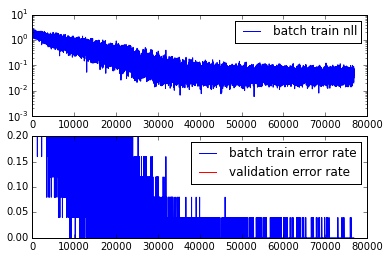

In [17]:
print "Setting network parameters from after epoch %d" % (best_params_epoch)
load_parameters(best_params)

print "Test error rate is %f%%" % (compute_error_rate(cifar10_test_stream) * 100.0,)

subplot(2, 1, 1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:, 0], train_nll_a[:, 1], label = "batch train nll")
legend()

subplot(2, 1, 2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:, 0], train_erros_a[:, 1], label = "batch train error rate")
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:, 0], validation_errors_a[:, 1], label = "validation error rate", color = "r")
ylim(0, 0.2)
legend()